In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

PATH = "test-data/dodgechev/"

#arch=resnext50
arch = resnet34
bs=12

 Want to have a look at the size of the images

In [2]:
def get_data(sz):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    return ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=4)

In [3]:
data = get_data(224)

In [4]:
fn = PATH + data.trn_ds.fnames[0]; fn

'test-data/dodgechev/train/chev/31. 636602192087472698.jpg'

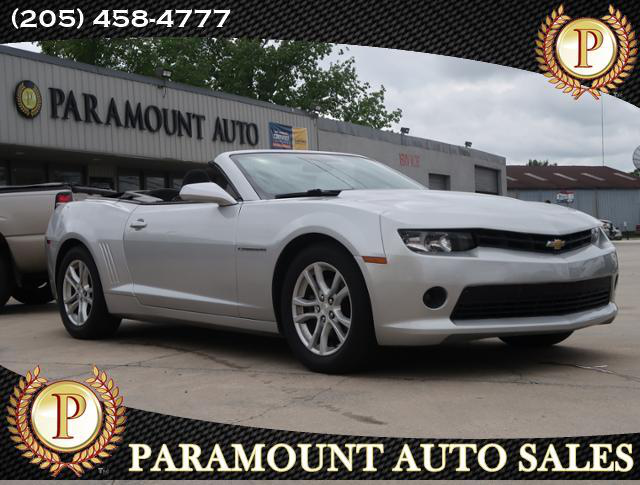

In [5]:
img = PIL.Image.open(fn); img

In [6]:
img.size

(640, 485)

In [7]:
size_d = {k: PIL.Image.open(PATH + k).size for k in data.trn_ds.fnames}

In [8]:
row_sz,col_sz = list(zip(*size_d.values()))
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

In [9]:
row_sz[:5]

array([ 640, 1280,  640,  344, 1280])

(array([65., 51., 22.,  7.,  3.,  0.,  0.,  1.,  0.,  1.]),
 array([ 200. ,  781.6, 1363.2, 1944.8, 2526.4, 3108. , 3689.6, 4271.2, 4852.8, 5434.4, 6016. ]),
 <a list of 10 Patch objects>)

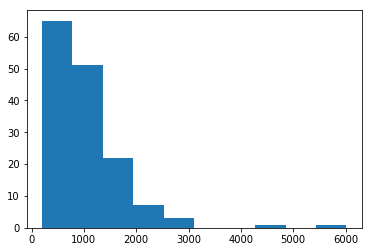

In [10]:
plt.hist(row_sz)

(array([12.,  9., 38., 18., 11., 10., 18.,  7.,  8.,  7.]),
 array([ 200.,  372.,  544.,  716.,  888., 1060., 1232., 1404., 1576., 1748., 1920.]),
 <a list of 10 Patch objects>)

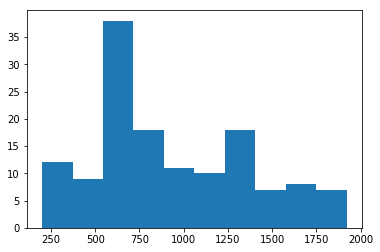

In [11]:
plt.hist(row_sz[row_sz<2000])

(array([75., 46., 18.,  7.,  2.,  0.,  0.,  1.,  0.,  1.]),
 array([ 142. ,  527.8,  913.6, 1299.4, 1685.2, 2071. , 2456.8, 2842.6, 3228.4, 3614.2, 4000. ]),
 <a list of 10 Patch objects>)

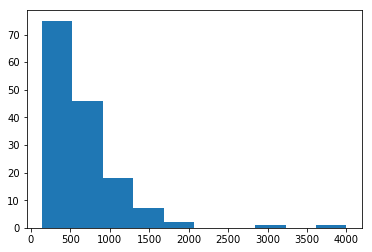

In [12]:
plt.hist(col_sz)

(array([ 7., 10., 11., 42., 11.,  6., 17., 12.,  5.,  6.]),
 array([142. , 226.9, 311.8, 396.7, 481.6, 566.5, 651.4, 736.3, 821.2, 906.1, 991. ]),
 <a list of 10 Patch objects>)

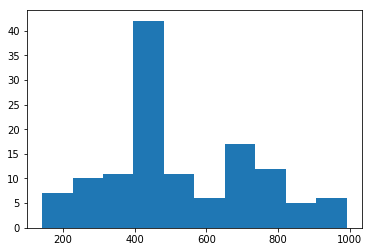

In [13]:
plt.hist(col_sz[col_sz<1000])

So how many images to we have in the training set and the validation set?

In [14]:
len(data.trn_ds)

150

In [15]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 3/3 [00:00<00:00,  3.64it/s]


In [16]:
lrf = learn.lr_find()

epoch      trn_loss   val_loss   accuracy                 
    0      1.598638   11269.021484 0.472222  



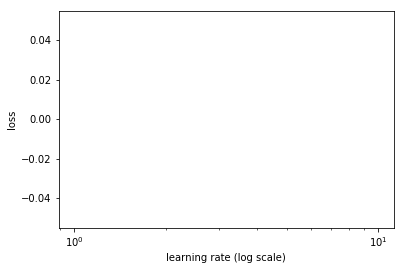

In [17]:
learn.sched.plot()

In [18]:
learn.fit(1e-2, 2)

epoch      trn_loss   val_loss   accuracy         
    0      0.778002   0.538233   0.666667  
    1      0.584799   0.393237   0.777778         



[array([0.39324]), 0.7777777711550394]

In [19]:
learn.precompute = False
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.498216   0.322485   0.833333  
    1      0.478954   0.384094   0.833333                  
    2      0.455182   0.392523   0.777778                  



[array([0.39252]), 0.7777777711550394]

In [20]:
learn.unfreeze()
lr=np.array([1e-4,1e-3,1e-2])

In [21]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.482219   0.248353   0.861111  
    1      0.419593   0.434514   0.861111                  
    2      0.429226   0.400161   0.833333                  
    3      0.326951   0.656523   0.722222                  
    4      0.314078   0.397695   0.805556                  
    5      0.263234   0.25591    0.888889                  
    6      0.213332   0.25634    0.888889                  



[array([0.25634]), 0.8888888955116272]

Increase the image size

In [22]:
data = get_data(299)
learn.freeze()
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.129373   0.247596   0.888889  
    1      0.12838    0.280599   0.861111                  
    2      0.11675    0.27319    0.861111                 
    3      0.119353   0.33112    0.805556                  
    4      0.138997   0.382214   0.833333                 
    5      0.122299   0.418838   0.805556                  
    6      0.128915   0.406803   0.805556                  



[array([0.4068]), 0.805555542310079]

In [23]:
learn.unfreeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                   
    0      0.098497   0.448087   0.833333  
    1      0.086655   0.332934   0.888889                   
    2      0.101615   0.269202   0.916667                   
    3      0.099409   0.286786   0.916667                   
    4      0.092828   0.277644   0.888889                   
    5      0.076696   0.320559   0.861111                   
    6      0.067442   0.271276   0.861111                   



[array([0.27128]), 0.8611111044883728]

In [24]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

accuracy(probs,y)

TypeError: torch.max received an invalid combination of arguments - got (numpy.ndarray, dim=int), but expected one of:
 * (torch.FloatTensor source)
 * (torch.FloatTensor source, torch.FloatTensor other)
      didn't match because some of the keywords were incorrect: dim
 * (torch.FloatTensor source, int dim)
 * (torch.FloatTensor source, int dim, bool keepdim)
